In [2]:
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import tqdm

import torchaudio
import torch
from sklearn.model_selection import train_test_split

import os
import sys

from transformers import AutoConfig, Wav2Vec2Processor, Wav2Vec2FeatureExtractor
from transformers import HubertModel, HubertConfig, Wav2Vec2Processor
import torch.nn as nn
import torch


d:\python\envs\labplnta\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = np.load('data.npy', allow_pickle=True)
labels = np.load('labels.npy', allow_pickle=True)

print(data.shape)
print(labels.shape)

(14577, 112000)
(14577,)


In [4]:
model_name_or_path = "facebook/hubert-base-ls960"

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path,)
target_sampling_rate = feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")


The target sampling rate: 16000


In [5]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=33, stratify=labels)

In [6]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(11661, 112000) (11661,)
(2916, 112000) (2916,)


In [7]:
#create a list of arrays for the training data
train_data = []
for i in range(len(x_train)):
    train_data.append(x_train[i])
    
#create a list of arrays for the testing data
test_data = []
for i in range(len(x_test)):
    test_data.append(x_test[i])
    
print(train_data[0])
print(test_data[0])

print(len(train_data), len(test_data))

[-0.00317383 -0.00302124 -0.00308228 ...  0.00765991  0.0071106
  0.00793457]
[0.0010376  0.00076294 0.0005188  ... 0.02801514 0.02929688 0.0307312 ]
11661 2916


In [8]:
features_train = feature_extractor(train_data, sampling_rate=target_sampling_rate)
features_test = feature_extractor(test_data, sampling_rate=target_sampling_rate)

print(features_train.keys())
print(features_test.keys())
print(features_train['input_values'][0])

dict_keys(['input_values'])
dict_keys(['input_values'])
[-0.474839   -0.45189515 -0.46107268 ...  1.1541741   1.0715762
  1.195473  ]


In [9]:
features_train['labels'] = [label for label in y_train]
features_test['labels'] = [label for label in y_test]

print(features_train['labels'][:50])

[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1]


In [10]:
# # createn a dataset type and use it for training on batches
# class Dataset(torch.utils.data.Dataset):
#     def __init__(self, encodings):
#         self.encodings = encodings

#     def __getitem__(self, idx):
#         item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
#         return item

#     def __len__(self):
#         return len(self.encodings.input_values)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        input_values = torch.tensor(self.encodings['input_values'][idx], dtype=torch.float)
        labels = torch.tensor(self.encodings['labels'][idx], dtype=torch.float).unsqueeze(0)  # Ensure labels are shaped correctly
        return {'input_values': input_values, 'labels': labels}

    def __len__(self):
        return len(self.encodings['input_values'])

    
train_dataset = Dataset(features_train)
test_dataset = Dataset(features_test)

print(train_dataset[9])
print(test_dataset[9])


{'input_values': tensor([-0.1920, -0.2757, -0.3699,  ..., -1.7401, -1.4472, -1.4681]), 'labels': tensor([0.])}
{'input_values': tensor([-0.0512, -0.0460, -0.0356,  ..., -0.0512, -0.0565, -0.0669]), 'labels': tensor([0.])}


In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

print(len(train_loader), len(test_loader))

11661 2916


In [12]:
print(f"Training input_values: {train_dataset[0]['input_values']}")
print(f"Training labels: {train_dataset[0]['labels']}")

Training input_values: tensor([-0.4748, -0.4519, -0.4611,  ...,  1.1542,  1.0716,  1.1955])
Training labels: tensor([0.])


In [13]:
class HubertForDepressionDetection(nn.Module):
    def __init__(self, hubert_model_name='facebook/hubert-base-ls960'):
        super(HubertForDepressionDetection, self).__init__()
        self.feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(hubert_model_name)
        self.hubert = HubertModel.from_pretrained(hubert_model_name)
        self.classifier = nn.Linear(self.hubert.config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input_values):
        outputs = self.hubert(input_values).last_hidden_state
        # Use the mean of the last hidden state as the input to the classifier
        mean_output = torch.mean(outputs, dim=1)
        logits = self.classifier(mean_output)
        probs = self.sigmoid(logits)
        return probs
    
    

In [14]:
model = HubertForDepressionDetection()



optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.BCELoss()

# Move model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

d:\python\envs\labplnta\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model f

HubertForDepressionDetection(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

In [39]:
from torch.utils.tensorboard import SummaryWriter

# Initialize TensorBoard writer
writer = SummaryWriter('runs/hubert_depression_detection_experiment')


In [15]:
def train(model, train_loader, optimizer, criterion, device, writer, epoch):
    model.train()
    total_loss = 0

    for batch_idx, batch in enumerate(train_loader):
        input_values = batch['input_values'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_values)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        # Log training loss
        if batch_idx % 10 == 0:  # Log every 10 batches
            writer.add_scalar('Training Loss', loss.item(), epoch * len(train_loader) + batch_idx)

    avg_loss = total_loss / len(train_loader)
    return avg_loss

def evaluate(model, test_loader, criterion, device, writer, epoch):
    model.eval()
    total_loss = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            input_values = batch['input_values'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_values)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(test_loader)

    # Calculate additional metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    val_preds_binary = [1 if p > 0.5 else 0 for p in all_preds]
    accuracy = accuracy_score(all_labels, val_preds_binary)
    precision = precision_score(all_labels, val_preds_binary)
    recall = recall_score(all_labels, val_preds_binary)
    f1 = f1_score(all_labels, val_preds_binary)
    
    # Log validation metrics
    writer.add_scalar('Validation Loss', avg_loss, epoch)
    writer.add_scalar('Validation Accuracy', accuracy, epoch)
    writer.add_scalar('Validation Precision', precision, epoch)
    writer.add_scalar('Validation Recall', recall, epoch)
    writer.add_scalar('Validation F1 Score', f1, epoch)

    return avg_loss, accuracy, precision, recall, f1

def save_model(model, optimizer, epoch, model_path):
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    model_save_path = os.path.join(model_path, f'model_epoch_{epoch}.pth')
    optimizer_save_path = os.path.join(model_path, f'optimizer_epoch_{epoch}.pth')
    torch.save(model.state_dict(), model_save_path)
    torch.save(optimizer.state_dict(), optimizer_save_path)
    print(f"Model and optimizer saved to {model_save_path} and {optimizer_save_path}")

def load_model(model_path, epoch):
    model = HubertForDepressionDetection()
    model_load_path = os.path.join(model_path, f'model_epoch_{epoch}.pth')
    optimizer_load_path = os.path.join(model_path, f'optimizer_epoch_{epoch}.pth')
    model.load_state_dict(torch.load(model_load_path))
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    optimizer.load_state_dict(torch.load(optimizer_load_path))
    
    model.to(device)
    return model, optimizer



In [41]:
# Training and evaluation setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HubertForDepressionDetection().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.BCELoss()
writer = SummaryWriter('runs/hubert_depression_detection_experiment')
num_epochs = 10
model_path = './hubert_depression_detection_model'

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device, writer, epoch)
    val_loss, accuracy, precision, recall, f1 = evaluate(model, test_loader, criterion, device, writer, epoch)
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    
    # Save the model after each epoch
    save_model(model, optimizer, epoch, model_path)

# Close the writer
writer.close()

Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

Epoch 1/10
Train Loss: 0.4007
Validation Loss: 0.1373
Accuracy: 0.9451, Precision: 0.8772, Recall: 0.9540, F1 Score: 0.9140
Model and optimizer saved to ./hubert_depression_detection_model\model_epoch_0.pth and ./hubert_depression_detection_model\optimizer_epoch_0.pth
Epoch 2/10
Train Loss: 0.1529
Validation Loss: 0.0631
Accuracy: 0.9787, Precision: 0.9631, Recall: 0.9675, F1 Score: 0.9653
Model and optimizer saved to ./hubert_depression_detection_model\model_epoch_1.pth and ./hubert_depression_detection_model\optimizer_epoch_1.pth
Epoch 3/10
Train Loss: 0.1051
Validation Loss: 0.0363
Accuracy: 0.9866, Precision: 0.9874, Recall: 0.9686, F1 Score: 0.9779
Model and optimizer saved to ./hubert_depression_detection_model\model_epoch_2.pth and ./hubert_depression_detection_model\optimizer_epoch_2.pth
Epoch 4/10
Train Loss: 0.0807
Validation Loss: 0.0376
Accuracy: 0.9859, Precision: 0.9942, Recall: 0.9596, F1 Score: 0.9766
Model and optimizer saved to ./hubert_depression_detection_model\mode

In [16]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in test_loader:
            input_values = batch['input_values'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_values)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(test_loader)

    return avg_loss, all_labels, all_preds



Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

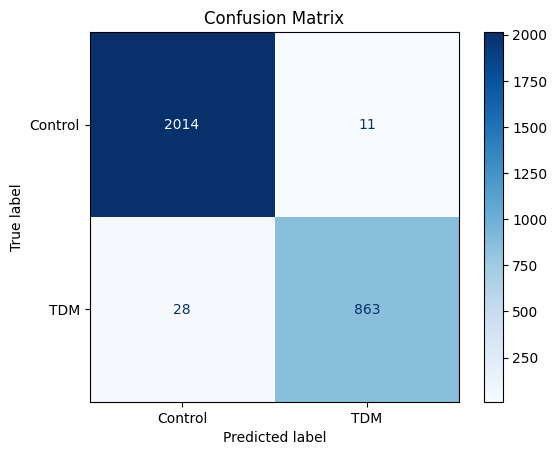

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model_path = './hubert_depression_detection_model_orig'

# Load the model
model, optimizer = load_model(model_path, 2)


# Perform inference on the test set
val_loss, all_labels, all_preds = evaluate(model, test_loader, criterion, device)

# Convert predictions to binary labels (0 or 1)
all_preds_binary = [1 if p > 0.5 else 0 for p in all_preds]

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds_binary)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'TDM'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

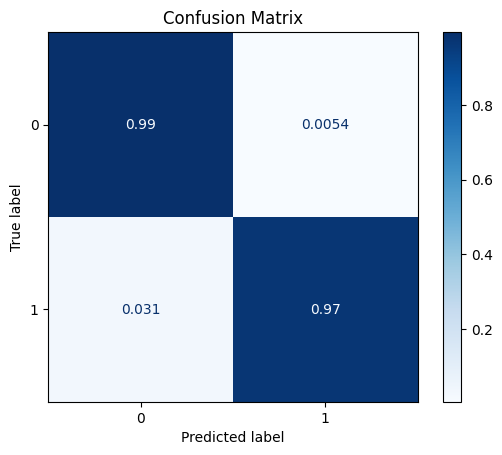

In [19]:
# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds_binary, normalize='true')
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()